In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import json
from datetime import datetime, date
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models
import statsmodels.api as sm
from scipy.stats import f
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Data sources
import yfinance as yf
from fredapi import Fred

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pd.options.display.max_rows = 500
%matplotlib inline 

# Gather Data

In [2]:
api_key = 'b27994ea92311f213e0e709cdd98849b' # hidden
fred = Fred(api_key)

Let's try for a less volatile time period

In [3]:
# Set period
start = datetime(2008, 1, 1)
end = date.today()

# Gather series
vix = fred.get_series('VIXCLS', start, end)
vix_lag_1month = vix.shift(21) # Also add previous values of volatility
interest_rates = fred.get_series('FEDFUNDS', start, end)
gdp = fred.get_series('GDP', start, end)
gdp_growth = gdp.pct_change() * 100
cpi = fred.get_series('CPIAUCSL', start, end)
unemployment = fred.get_series('UNRATE', start, end)
housing_starts = fred.get_series('HOUST', start, end)
home_prices = fred.get_series('CSUSHPINSA', start, end)
usd_idx = yf.download('DX-Y.NYB', start, end)['Adj Close']
corporate_bond_yields = fred.get_series('BAMLC0A4CBBBEY', start, end)
treasury_yields = fred.get_series('DGS10', start, end)

# Gather S&P500 Data
sp500 = yf.download('^GSPC', start=start, end=end)
# Gather Returns in unit percentage
sp500['Returns'] = sp500['Adj Close'].pct_change() * 100
# Gather response variable
squared_returns = np.square(sp500['Returns'])
volatility = np.sqrt(squared_returns.rolling(window=21).sum())
# Logged volatility
log_volatility = np.log(volatility)
# Create 1-month lagged AR term
volatility_lag_1month = log_volatility.shift(21)
# Create 1-week lagged AR term
volatility_lag_1week = log_volatility.shift(5)

# Gather Volume regressor
volume = sp500['Volume']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
# Combine all macro series into one dataframe
combined_df = pd.concat([
    log_volatility,
    volatility_lag_1week,
    volatility_lag_1month,
    volume, 
    vix_lag_1month,
    interest_rates,
    gdp,
    gdp_growth,
    cpi,
    unemployment,
    housing_starts,
    home_prices,
    usd_idx,
    corporate_bond_yields,
    treasury_yields
], axis=1)

# Set columns
combined_df.columns = [
    "Logged_Volatility",
    "volatility_lag_1week",
    "Volatility_Lag_One_Month",
    "Volume",
    'VIX_Lag_One_Month',
    'Interest_Rates', 
    'GDP', 
    'GDP_Growth',
    'CPI', 
    'Unemployment_Rate', 
    'Housing_Starts', 
    'Home_Prices', 
    'US_Dollar_Index', 
    'Corporate_Bond_Yields', 
    'Ten_Year_Treasury_Yield'
]

combined_df = sm.add_constant(combined_df)
# Forward Fill imputation
combined_df.fillna(method='ffill', inplace=True)
# Let's select from 2000 onwards
combined_df = combined_df[combined_df.index.get_loc('2010-01-01'):combined_df.index.get_loc('2019-01-01')]
# Let's view our dataframe
combined_df.describe()

,const,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
count,2408.0,2408.000000,2408.000000,2408.000000,2.408000e+03,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,1.0,1.233321,1.232976,1.231350,3.712963e+09,16.998588,0.441985,17642.939507,0.994994,235.067673,6.500332,960.753738,165.702071,87.301051,3.989319,2.432824
std,0.0,0.454221,0.452111,0.449565,8.458039e+08,5.776856,0.577014,1780.806680,0.433561,9.601243,1.969033,246.581846,21.811453,8.222655,0.505363,0.560458
min,1.0,0.093089,0.093089,0.093089,1.025000e+09,9.140000,0.070000,14764.610000,0.033265,217.199000,3.700000,517.000000,133.996000,72.930000,3.160000,1.370000
25%,1.0,0.920107,0.921865,0.925154,3.224592e+09,13.020000,0.100000,16207.115000,0.666540,228.590000,4.800000,723.000000,144.310000,80.169998,3.580000,2.000000
50%,1.0,1.181258,1.178750,1.183143,3.591965e+09,15.590000,0.160000,17804.228000,1.022055,236.222000,6.100000,1007.000000,166.248000,84.150002,3.910000,2.360000
75%,1.0,1.534230,1.528121,1.518129,4.100412e+09,19.202500,0.400000,18941.824000,1.342486,241.317250,8.200000,1177.000000,183.960750,95.250000,4.360000,2.830000
max,1.0,2.628552,2.628552,2.628552,1.061781e+10,48.000000,2.270000,20917.867000,1.865187,252.772000,9.900000,1357.000000,205.372000,103.290001,5.580000,4.010000


In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize volume 
combined_df['Volume'] = scaler.fit_transform(combined_df[['Volume']])

# Standardize GDP
combined_df['GDP'] = scaler.fit_transform(combined_df[['GDP']])

# Scale housing starts
combined_df['Housing_Starts'] = scaler.fit_transform(combined_df[['Housing_Starts']])

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame and the model formula is defined
formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'

# Fit the model on the entire dataset
model = smf.ols(formula=formula, data=combined_df).fit()

# Calculate leverage (hat) values
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized_internal

# Calculate Cook's distance
cooks_d = influence.cooks_distance[0]

# Leverage threshold (commonly used threshold is 2p/n
n = len(combined_df)
p = len(model.params)
leverage_threshold = 2 * p / n

# Outliers based on studentized residuals (commonly used threshold is |t| > 2 for a smaller dataset)
studentized_residuals_threshold = 2

# High Cook's distance threshold (commonly used threshold is 4/n)
cooks_d_threshold = f.ppf(0.5, p, n - p)

# Identify high leverage points, outliers, and high Cook's distance points
high_leverage_points = np.where(leverage > leverage_threshold)[0]
outliers = np.where(np.abs(studentized_residuals) > studentized_residuals_threshold)[0]
high_cooks_d_points = np.where(cooks_d > cooks_d_threshold)[0]

# Combine all identified points
all_indices_to_remove = np.unique(np.concatenate([high_leverage_points, outliers, high_cooks_d_points]))

print(f'Indices to remove: {all_indices_to_remove}')

# Remove the identified points from the dataset
# Convert integer positions to datetime values
indices_to_remove = combined_df.index[all_indices_to_remove]

# Drop rows based on datetime index values
cleaned_df = combined_df.drop(index=indices_to_remove)

print(f'Original dataset size: {combined_df.shape}')
print(f'Cleaned dataset size: {cleaned_df.shape}')

Indices to remove: [   0    2   14   61   77   78   84   85   90   91   92   93   94   95
   96   97   98  100  101  102  103  104  105  107  108  109  110  113
  114  122  123  124  125  248  259  267  268  269  270  271  272  273
  274  275  276  277  278  279  282  284  285  300  301  302  303  304
  305  306  308  309  310  423  426  427  428  429  430  431  432  433
  434  435  436  437  438  439  440  441  442  443  444  447  449  450
  451  455  456  457  459  460  467  469  473  481  482  483  484  485
  486  487  488  489  490  506  526  527  528  532  533  534  555  556
  557  562  715  716 1115 1128 1279 1315 1316 1317 1318 1320 1510 1512
 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526
 1527 1528 1529 1531 1532 1581 1596 1600 1601 1619 1734 1755 1783 1787
 1788 1789 1835 1995 2032 2033 2034 2128 2165 2166 2167 2168 2169 2170
 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184
 2185 2186 2187 2188 2189 2190 2194 2200 2201 2208 2209 22

In [7]:
cleaned_df['Logged_Volatility'].describe()

count    2168.000000
mean        1.185172
std         0.401604
min         0.093089
25%         0.909173
50%         1.155025
75%         1.464432
max         2.568492
Name: Logged_Volatility, dtype: float64

/var/folders/pl/jj87skw96cbcsdl_06122bwr0000gn/T/ipykernel_59237/1732864786.py:53: RuntimeWarning: divide by zero encountered in divide
  zz = np.sqrt(cooks_d_threshold * (1 / xx) * (1 - xx))


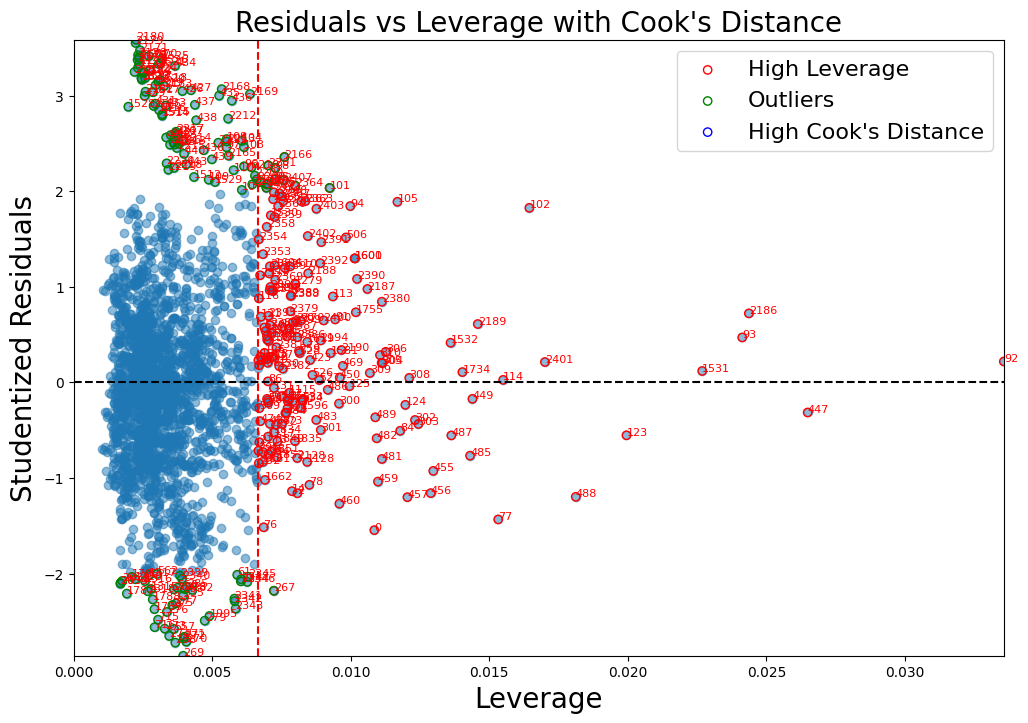

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import f

# Fit the model on the entire dataset
model = smf.ols(formula=formula, data=combined_df).fit()

# Calculate leverage (hat) values
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# Calculate studentized residuals
studentized_residuals = influence.resid_studentized_internal

# Calculate Cook's distance
cooks_d = influence.cooks_distance[0]

# Leverage threshold (commonly used threshold is 2*(p+1)/n, where p is the number of predictors)
n = len(combined_df)
p = len(model.params) - 1
leverage_threshold = 2 * p / n

# Outliers based on studentized residuals (commonly used threshold is |t| > 2)
studentized_residuals_threshold = 2

# High Cook's distance threshold (commonly used threshold is the 50th percentile of F(p, n-p))
cooks_d_threshold = f.ppf(0.5, p, n - p)

# Identify high leverage points, outliers, and high Cook's distance points
high_leverage_points = np.where(leverage > leverage_threshold)[0]
outliers = np.where(np.abs(studentized_residuals) > studentized_residuals_threshold)[0]
high_cooks_d_points = np.where(cooks_d > cooks_d_threshold)[0]

# Combine all identified points
all_influential_points = np.unique(np.concatenate([high_leverage_points, outliers, high_cooks_d_points]))

# Plotting the influential points
plt.figure(figsize=(12, 8))
plt.scatter(leverage, studentized_residuals, alpha=0.5)
plt.scatter(leverage[high_leverage_points], studentized_residuals[high_leverage_points], edgecolor='r', facecolor='none', label='High Leverage')
plt.scatter(leverage[outliers], studentized_residuals[outliers], edgecolor='g', facecolor='none', label='Outliers')
plt.scatter(leverage[high_cooks_d_points], studentized_residuals[high_cooks_d_points], edgecolor='b', facecolor='none', label='High Cook\'s Distance')

# Label the influential points
for i in all_influential_points:
    plt.annotate(i, (leverage[i], studentized_residuals[i]), fontsize=8, color='red')

# Add Cook's distance contours
xx, yy = np.meshgrid(np.linspace(0, max(leverage), 100), np.linspace(min(studentized_residuals), max(studentized_residuals), 100))
zz = np.sqrt(cooks_d_threshold * (1 / xx) * (1 - xx))
plt.contour(xx, yy, zz, levels=[0.5, 1, 1.5], colors='grey', linestyles='--')

plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=leverage_threshold, color='red', linestyle='--')
plt.xlabel('Leverage', fontsize = 20)
plt.ylabel('Studentized Residuals',  fontsize = 20)
plt.title('Residuals vs Leverage with Cook\'s Distance',  fontsize = 20)
plt.legend(fontsize=16)
plt.show()

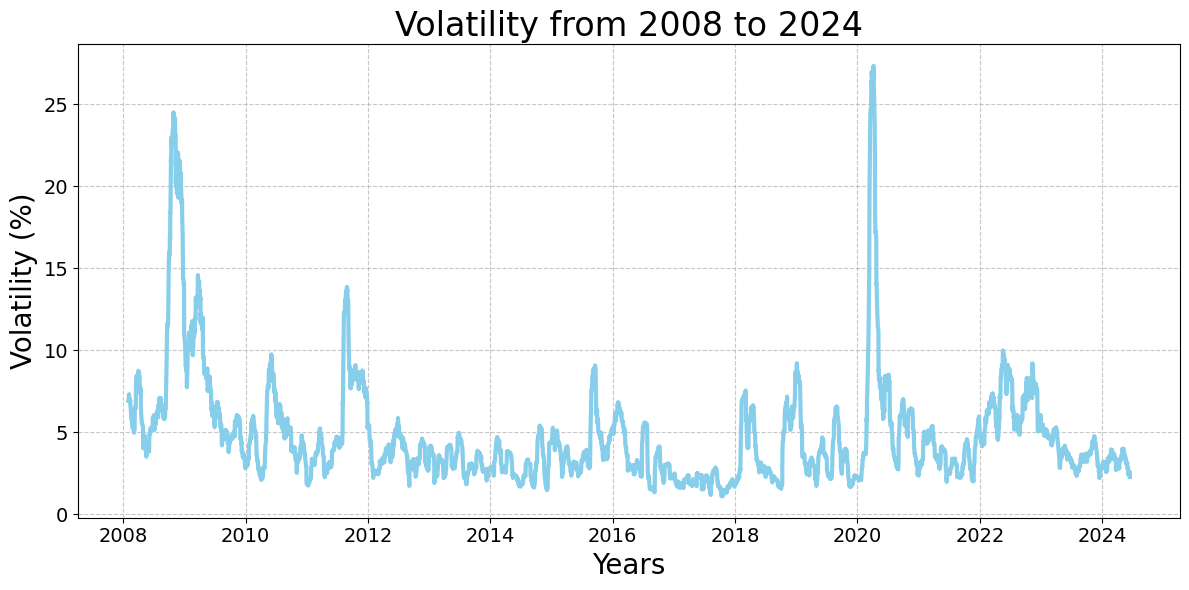

In [29]:
plt.figure(figsize=(12, 6))

# Line plot with customizations
plt.plot(volatility, color='skyblue', linestyle='-', linewidth=3)

# Labels and title
plt.xlabel('Years', fontsize=20)
plt.ylabel('Volatility (%)', fontsize=20)
plt.title('Volatility from 2008 to 2024', fontsize=24)

# Customize ticks and tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Gridlines for better readability
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Tight layout
plt.tight_layout()

# Show plot
plt.show()

In [69]:
combined_df.drop('const', axis=1).describe()

,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
count,2408.000000,2408.000000,2408.000000,2.408000e+03,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,1.233321,1.232976,1.231350,3.712963e+09,16.998588,0.441985,17642.939507,0.994994,235.067673,6.500332,960.753738,165.702071,87.301051,3.989319,2.432824
std,0.454221,0.452111,0.449565,8.458039e+08,5.776856,0.577014,1780.806680,0.433561,9.601243,1.969033,246.581846,21.811453,8.222655,0.505363,0.560458
min,0.093089,0.093089,0.093089,1.025000e+09,9.140000,0.070000,14764.610000,0.033265,217.199000,3.700000,517.000000,133.996000,72.930000,3.160000,1.370000
25%,0.920107,0.921865,0.925154,3.224592e+09,13.020000,0.100000,16207.115000,0.666540,228.590000,4.800000,723.000000,144.310000,80.169998,3.580000,2.000000
50%,1.181258,1.178750,1.183143,3.591965e+09,15.590000,0.160000,17804.228000,1.022055,236.222000,6.100000,1007.000000,166.248000,84.150002,3.910000,2.360000
75%,1.534230,1.528121,1.518129,4.100412e+09,19.202500,0.400000,18941.824000,1.342486,241.317250,8.200000,1177.000000,183.960750,95.250000,4.360000,2.830000
max,2.628552,2.628552,2.628552,1.061781e+10,48.000000,2.270000,20917.867000,1.865187,252.772000,9.900000,1357.000000,205.372000,103.290001,5.580000,4.010000


In [11]:
# Let's view our dataset
combined_df

,const,Logged_Volatility,volatility_lag_1week,Volatility_Lag_One_Month,Volume,VIX_Lag_One_Month,Interest_Rates,GDP,GDP_Growth,CPI,Unemployment_Rate,Housing_Starts,Home_Prices,US_Dollar_Index,Corporate_Bond_Yields,Ten_Year_Treasury_Yield
2010-01-01,1.0,1.031928,1.213919,1.533359,-1.934624,22.46,0.11,-1.616642,0.773729,217.488,9.8,-1.406534,145.003,77.860001,5.58,3.85
2010-01-04,1.0,1.173254,1.225838,1.523584,0.329267,21.25,0.11,-1.616642,0.773729,217.488,9.8,-1.406534,145.003,77.529999,5.54,3.85
2010-01-05,1.0,1.143235,1.217605,1.538719,-1.445012,22.10,0.11,-1.616642,0.773729,217.488,9.8,-1.406534,145.003,77.620003,5.43,3.77
2010-01-06,1.0,1.127724,1.068143,1.545416,1.489658,23.69,0.11,-1.616642,0.773729,217.488,9.8,-1.406534,145.003,77.489998,5.42,3.85
2010-01-07,1.0,1.132895,1.059598,1.454985,1.842083,22.66,0.11,-1.616642,0.773729,217.488,9.8,-1.406534,145.003,77.910004,5.40,3.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25,1.0,1.964023,1.865120,1.838038,-1.299972,18.90,2.27,1.839395,0.572809,252.767,3.9,0.544542,204.696,96.550003,4.69,2.74
2018-12-26,1.0,2.158567,1.851477,1.707134,0.634767,19.02,2.27,1.839395,0.572809,252.767,3.9,0.544542,204.696,97.050003,4.74,2.81
2018-12-27,1.0,2.147240,1.879293,1.689447,0.503823,18.49,2.27,1.839395,0.572809,252.767,3.9,0.544542,204.696,96.480003,4.70,2.77
2018-12-28,1.0,2.146619,1.875991,1.637483,0.018303,18.79,2.27,1.839395,0.572809,252.767,3.9,0.544542,204.696,96.389999,4.71,2.72


Text(0.5, 0, 'standard deviation of logged returns')

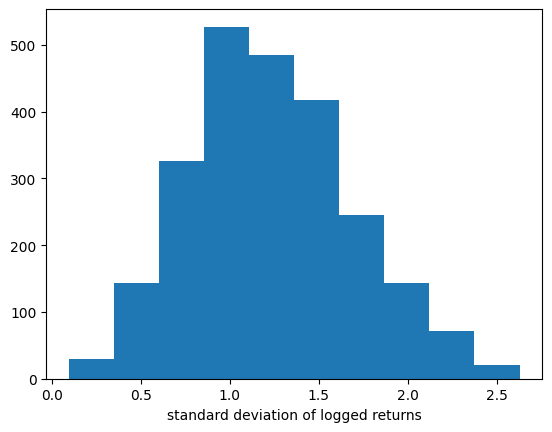

In [12]:
plt.hist(combined_df['Logged_Volatility'])
plt.xlabel("standard deviation of logged returns")

<Figure size 1000x600 with 0 Axes>

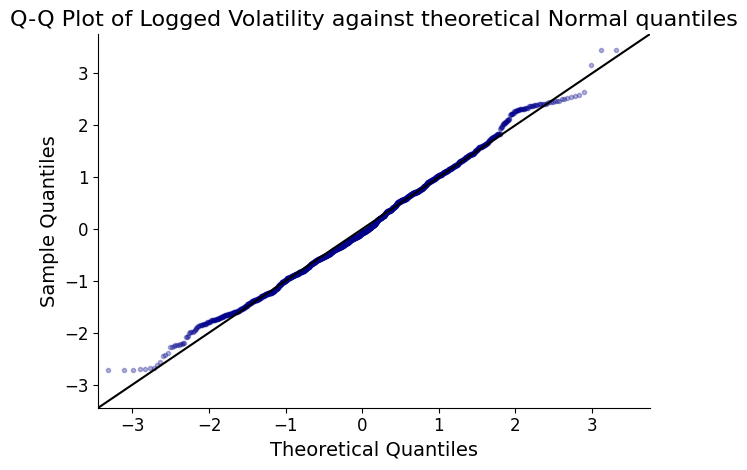

In [13]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create ProbPlot instance and Q-Q plot
pp = sm.ProbPlot(cleaned_df['Logged_Volatility'], fit=True)
qq = pp.qqplot(marker='.', markerfacecolor='darkblue', markeredgecolor='darkblue', alpha=0.3)

# Add a 45-degree line for reference
sm.qqline(qq.axes[0], line='45', fmt='k--')

# Add title and labels
plt.title("Q-Q Plot of Logged Volatility against theoretical Normal quantiles", fontsize=16)
plt.xlabel("Theoretical Quantiles", fontsize=14)
plt.ylabel("Sample Quantiles", fontsize=14)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Customize ticks and tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Plot data

In [14]:
# plt.figure(figsize=(7,7))
# plt.plot(gdp, data=combined_df)
# plt.xlabel('Years')
# plt.ylabel('GDP in billions')
# plt.title('US GDP from 2000-2024 in billions')

# Regression

Plot 1: Fig 1 - Volatility Before and After.png

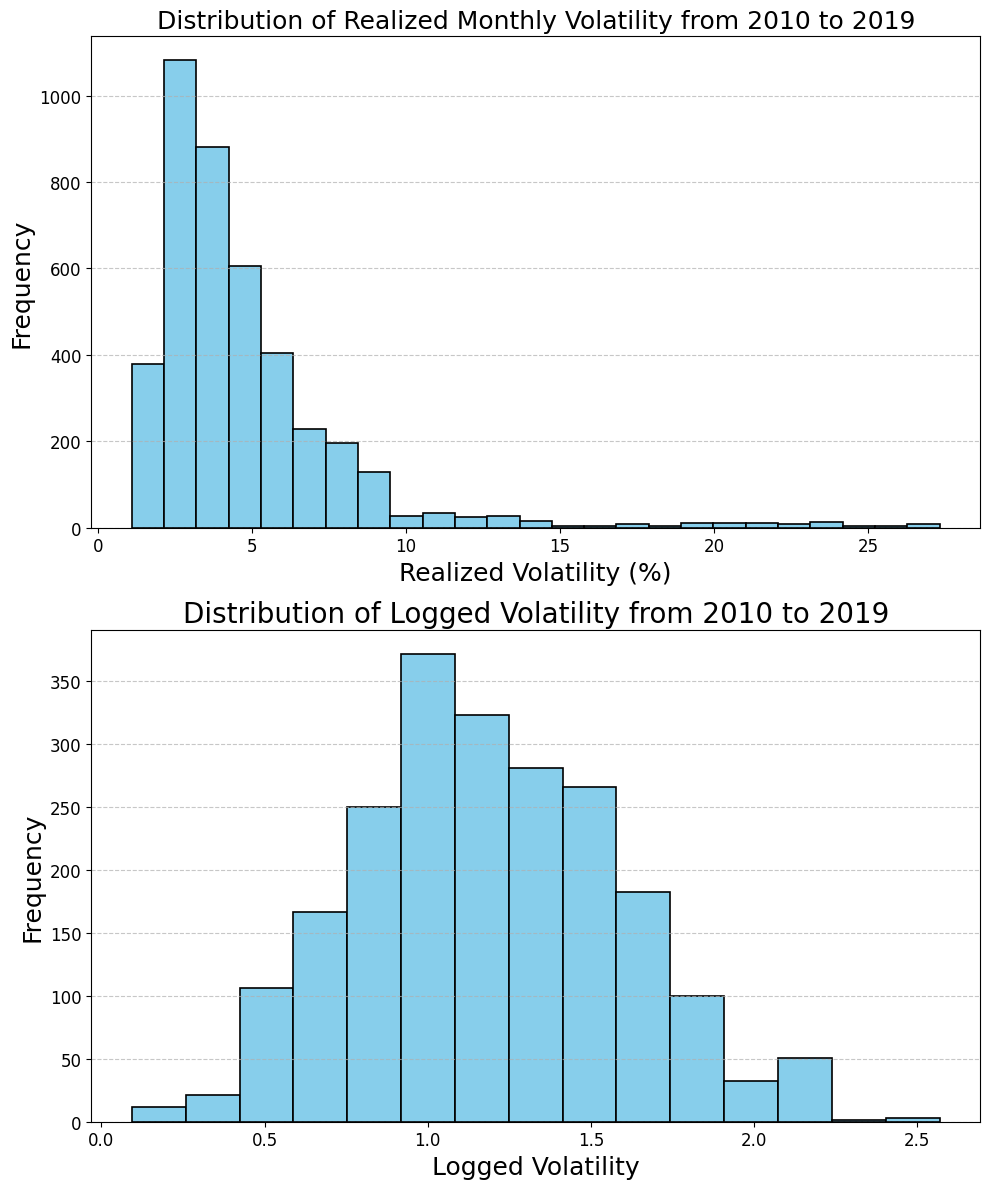

In [59]:


fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10, 12))
# First subplot: Distribution of Realized Monthly Volatility
axes[0].hist(volatility, bins=25, color='skyblue', edgecolor='black', linewidth=1.2)

# Customize titles and labels for the first subplot
axes[0].set_title("Distribution of Realized Monthly Volatility from 2010 to 2019", fontsize=18)
axes[0].set_xlabel("Realized Volatility (%)", fontsize=18)
axes[0].set_ylabel("Frequency", fontsize=18)

# Add gridlines for better readability
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Second subplot: Distribution of Logged Volatility
axes[1].hist(cleaned_df['Logged_Volatility'], bins=15, color='skyblue', edgecolor='black', linewidth=1.2)

# Customize titles and labels for the second subplot
axes[1].set_title("Distribution of Logged Volatility from 2010 to 2019", fontsize=20)
axes[1].set_xlabel("Logged Volatility", fontsize=18)
axes[1].set_ylabel("Frequency", fontsize=18)

# Add gridlines for better readability
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and spacing between subplots
plt.tight_layout()

# Display the combined plot
plt.show()

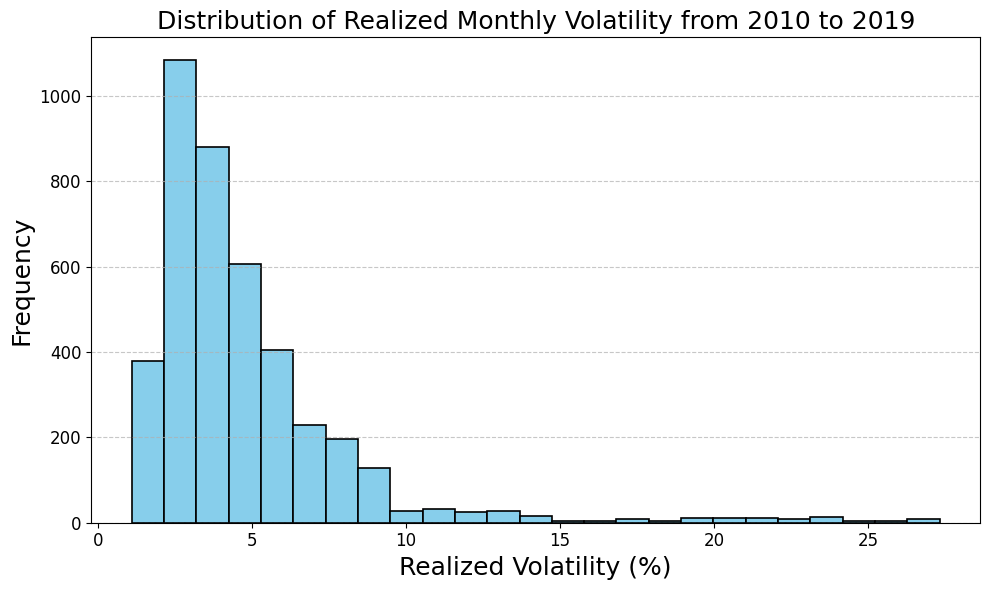

In [46]:


plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot histogram with customizations
plt.hist(volatility, bins=25, color='skyblue', edgecolor='black', linewidth=1.2)

# Add titles and labels
plt.title("Distribution of Realized Monthly Volatility from 2010 to 2019", fontsize=18)
plt.xlabel("Realized Volatility (%)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend if needed
# plt.legend(['Volatility'], loc='best')

# Show plot
plt.tight_layout()  # Adjust spacing to prevent clipping of labels
plt.show()

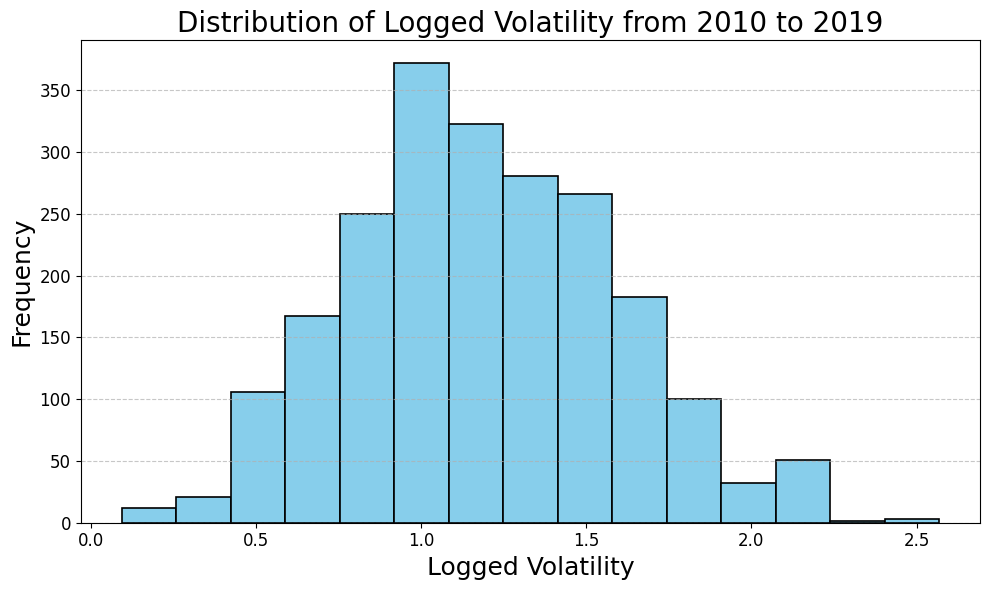

In [51]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot histogram with customizations
plt.hist(cleaned_df['Logged_Volatility'], bins=15, color='skyblue', edgecolor='black', linewidth=1.2)

# Add titles and labels
plt.title("Distribution of Logged Volatility from 2010 to 2019", fontsize=20)
plt.xlabel("Logged Volatility", fontsize=18)
plt.ylabel("Frequency", fontsize=18)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks and tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()  # Adjust spacing to prevent clipping of labels
plt.show()

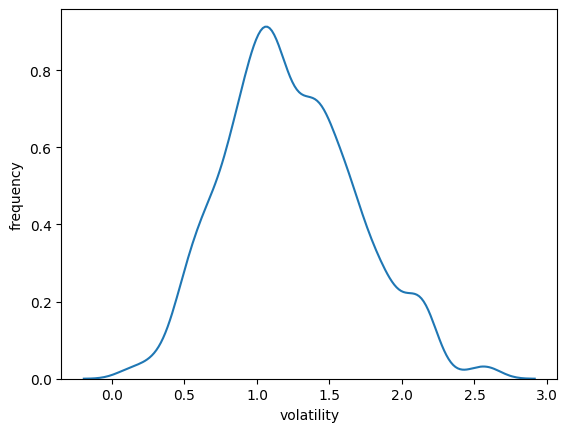

In [17]:
# Histogram of response
sns.kdeplot(combined_df['Logged_Volatility'])
plt.ylabel('frequency')
plt.xlabel('volatility')
plt.show()
# sns.kdeplot(vix)

# Scale & Standardize data

In [18]:
# Test model - here before scaling to demonstrate use of standardization
# Fit the multivariable regression model
test = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     229.8
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -540.70
No. Observations:                2408   AIC:                             1109.
Df Residuals:                    2394   BIC:                             1190.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [19]:
print(combined_df.describe())

        const  Logged_Volatility  volatility_lag_1week  \
count  2408.0        2408.000000           2408.000000   
mean      1.0           1.233321              1.232976   
std       0.0           0.454221              0.452111   
min       1.0           0.093089              0.093089   
25%       1.0           0.920107              0.921865   
50%       1.0           1.181258              1.178750   
75%       1.0           1.534230              1.528121   
max       1.0           2.628552              2.628552   

       Volatility_Lag_One_Month        Volume  VIX_Lag_One_Month  \
count               2408.000000  2.408000e+03        2408.000000   
mean                   1.231350  2.596668e-16          16.998588   
std                    0.449565  1.000208e+00           5.776856   
min                    0.093089 -3.178657e+00           9.140000   
25%                    0.925154 -5.775235e-01          13.020000   
50%                    1.183143 -1.430862e-01          15.590000   
7

In [20]:
# Test model
# Fit the multivariable regression model
test1 = smf.ols(formula = 'Logged_Volatility ~ volatility_lag_1week + VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + GDP_Growth + CPI + Unemployment_Rate + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     229.8
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -540.70
No. Observations:                2408   AIC:                             1109.
Df Residuals:                    2394   BIC:                             1190.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [21]:
# Fit the multivariable regression model - WITHOUT GDP_Growth
test_2 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP + CPI + Unemployment_Rate + Housing_Starts + Home_Prices + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_2.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     224.1
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -609.56
No. Observations:                2408   AIC:                             1245.
Df Residuals:                    2395   BIC:                             1320.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [22]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices
test_3 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + Housing_Starts + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_3.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     287.2
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -567.60
No. Observations:                2408   AIC:                             1157.
Df Residuals:                    2397   BIC:                             1221.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [23]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Unemployment_Rate
test_4 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_4.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     331.6
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -619.32
No. Observations:                2408   AIC:                             1257.
Df Residuals:                    2399   BIC:                             1309.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [24]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts, volatility_lag_1week

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_5 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_5.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     318.7
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                -568.81
No. Observations:                2408   AIC:                             1158.
Df Residuals:                    2398   BIC:                             1215.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [25]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_6 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + volatility_lag_1week + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=combined_df).fit()

# Print the model summary
print(test_6.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1639.
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                 962.78
No. Observations:                2408   AIC:                            -1904.
Df Residuals:                    2397   BIC:                            -1840.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# Outliers

In [26]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts - AND WITH INFLUENTIAL POINTS REMOVED

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_7 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=cleaned_df).fit()

# Print the model summary
print(test_7.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     421.6
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:35:22   Log-Likelihood:                 1.8513
No. Observations:                2168   AIC:                             16.30
Df Residuals:                    2158   BIC:                             73.11
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [27]:
# Fit the multivariable regression model - WITHOUT GDP, CPI, Home_Prices, Housing_Starts, Unemployment_Rate - AND WITH INFLUENTIAL POINTS REMOVED

# Consider using this one; has lowest AIC, all terms significant, and ensures that VIFs are (relatively) low

test_8 = smf.ols(formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + Interest_Rates + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield', data=train_df).fit()

# Print the model summary
print(test_8.summary())

NameError: name 'train_df' is not defined

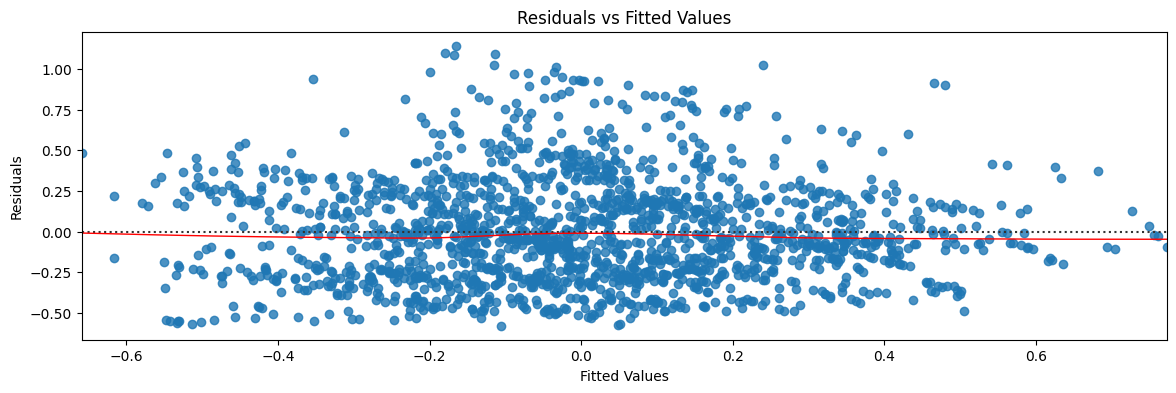

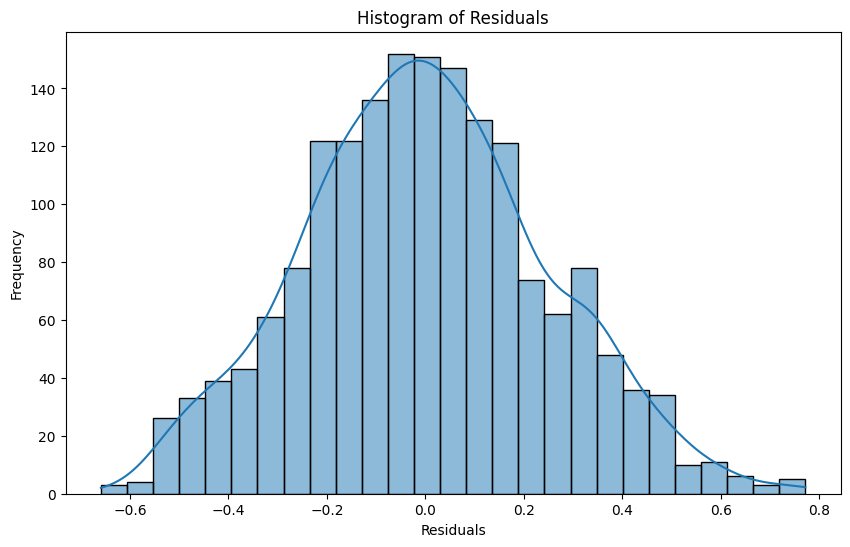

In [ ]:
# Extract residuals and fitted values
resids = test_8.resid
fitted_values = test_8.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

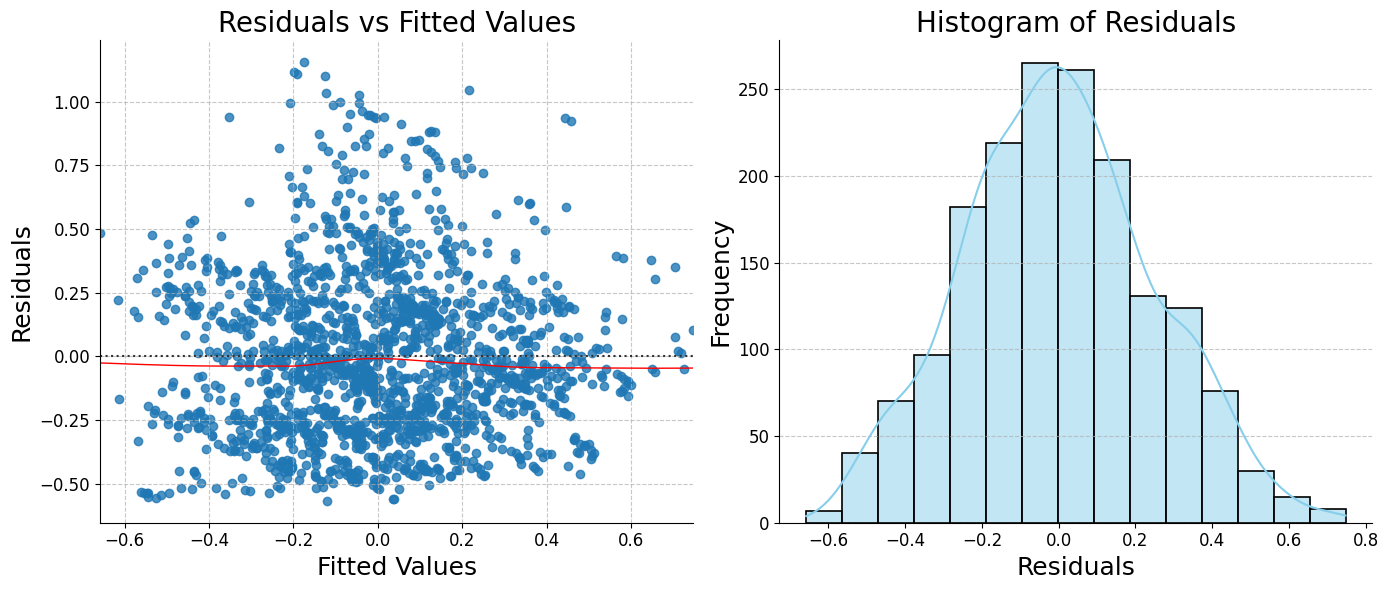

In [78]:
# Set up the figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

### Plot 1: Residuals vs Fitted Values ###

# Create residual plot with seaborn in subplot 1
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1}, ax=ax1)

# Customize labels and title for subplot 1
ax1.set_xlabel('Fitted Values', fontsize=18)
ax1.set_ylabel('Residuals', fontsize=18)
ax1.set_title('Residuals vs Fitted Values', fontsize=20)

# Remove top and right spines for subplot 1
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Customize ticks and tick labels for subplot 1
ax1.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines for subplot 1
ax1.grid(axis='both', linestyle='--', alpha=0.7)

### Plot 2: Histogram of Residuals ###

# Create histogram of residuals with KDE plot using seaborn in subplot 2
sns.histplot(resids, bins=15, kde=True, color='skyblue', edgecolor='black', linewidth=1.2, ax=ax2)

# Customize labels and title for subplot 2
ax2.set_xlabel('Residuals', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_title('Histogram of Residuals', fontsize=20)

# Remove top and right spines for subplot 2
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Customize ticks and tick labels for subplot 2
ax2.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines for subplot 2
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show combined plot
plt.show()

<Figure size 1000x600 with 0 Axes>

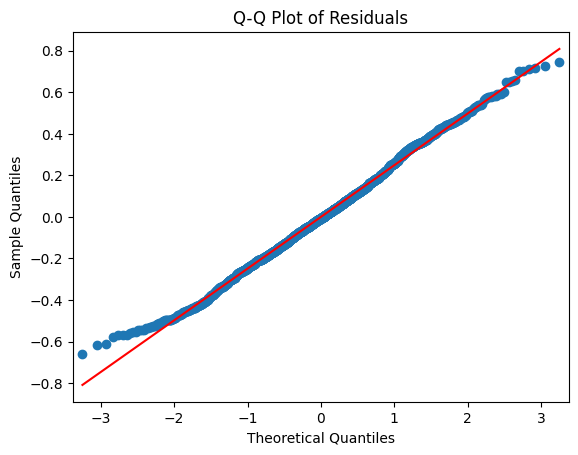

In [80]:
# Create Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(resids, line='r')
# stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

<Figure size 1000x800 with 0 Axes>

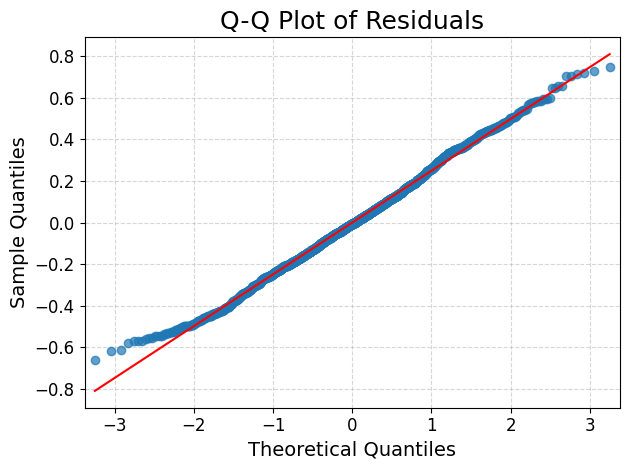

In [82]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# Create Q-Q plot of residuals
plt.figure(figsize=(10, 8))  # Adjust the figure size for better visibility

# Use statsmodels to create Q-Q plot
sm.qqplot(resids, line='r', alpha=0.7, color='b')  # 'line'='45' adds a diagonal reference line
plt.title('Q-Q Plot of Residuals', fontsize=18)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Sample Quantiles', fontsize=14)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

# Multicollinearity

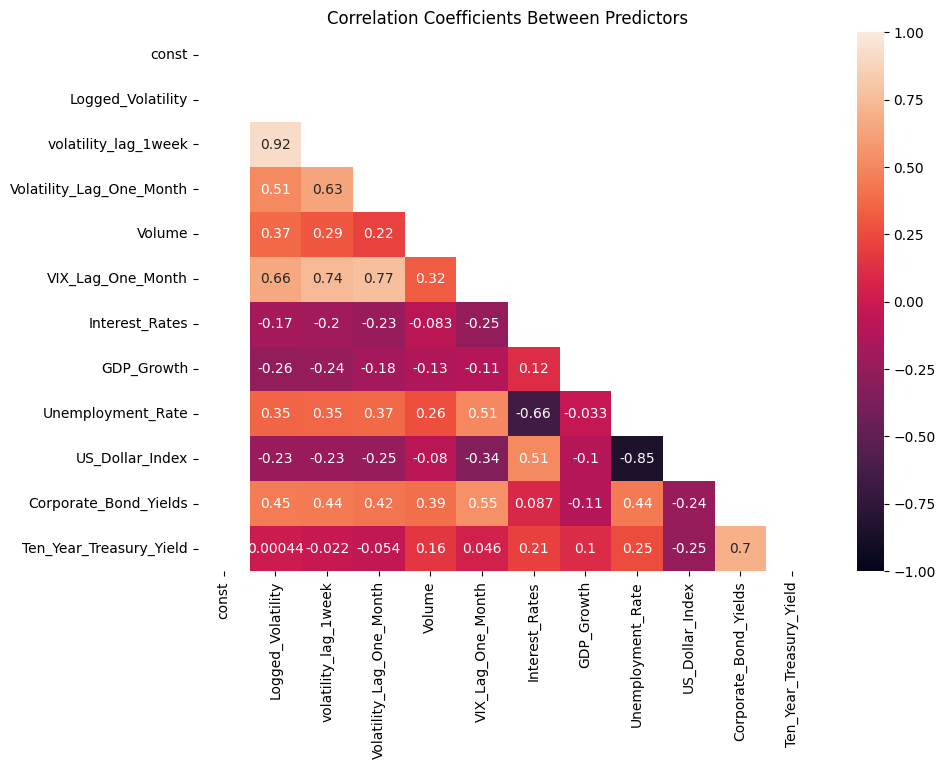

In [ ]:
# Test for multicollinearity - Remove GDP, CPI, Home_Prices, Housing_Starts
plt.figure(figsize=(10,7))
predictors = combined_df.drop(columns=["CPI", 'GDP', 'Home_Prices', 'Housing_Starts'])
mask = np.triu(np.ones_like(predictors.corr(), dtype=bool))
sns.heatmap(predictors.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients Between Predictors')
plt.show()

# VIF Test

In [53]:
# VIF test

# Drop the response variable 
X = combined_df.drop(columns=['Logged_Volatility', 'volatility_lag_1week', 'GDP', 'CPI', 'Housing_Starts', 'Home_Prices', 'Unemployment_Rate'])

# Calculate VIF for each explanatory variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     feature           VIF
0                      const  68945.695570
1       volatility_lag_1week      2.609561
2   Volatility_Lag_One_Month      2.750637
3                     Volume      1.307055
4          VIX_Lag_One_Month      4.422032
5             Interest_Rates     21.387262
6                        GDP    404.533739
7                 GDP_Growth      1.378551
8                        CPI    100.231352
9          Unemployment_Rate    165.309032
10            Housing_Starts     14.771072
11               Home_Prices     52.719333
12           US_Dollar_Index     11.149792
13     Corporate_Bond_Yields      8.075064
14   Ten_Year_Treasury_Yield      5.849625


# ANOVA

In [ ]:
# ANOVA
anova_result = anova_lm(test_model, train_model)
print(anova_result)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0    1726.0  106.811652      0.0       NaN       NaN       NaN
1    1725.0  106.397494      1.0  0.414159  6.714664  0.009643


# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# Define the predictors and response
X = combined_df.drop(columns=['Logged_Volatility'])
y = combined_df['Logged_Volatility']

# Fit a Ridge regression model
ridge = Ridge(alpha=1.0)
ridge_scores = cross_val_score(ridge, X, y, cv=5)
print(f'Ridge Regression CV Scores: {ridge_scores.mean()}')

# Fit a Lasso regression model
lasso = Lasso(alpha=0.1)
lasso_scores = cross_val_score(lasso, X, y, cv=5)
print(f'Lasso Regression CV Scores: {lasso_scores.mean()}')

# Plots

In [ ]:
fig, axs  = plt.subplots(2, 2,figsize=(12, 8))
fig.suptitle('US Economic indicators since 2000')

axs[0][0].plot(gdp)
axs[0][0].set_title("Nominal US GDP")
axs[0,0].set_ylabel("$Bn")

In [ ]:
# Create Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Prediction

In [ ]:
# TEST PREDICTION

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
test_model = smf.ols(formula=formula, data=train_df).fit()
print(test_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     401.9
Date:                Sat, 15 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:02:59   Log-Likelihood:                -44.007
No. Observations:                1734   AIC:                             104.0
Df Residuals:                    1726   BIC:                             147.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     353.7
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:41:46   Log-Likelihood:                -40.639
No. Observations:                1734   AIC:                             99.28
Df Residuals:                    1725   BIC:                             148.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

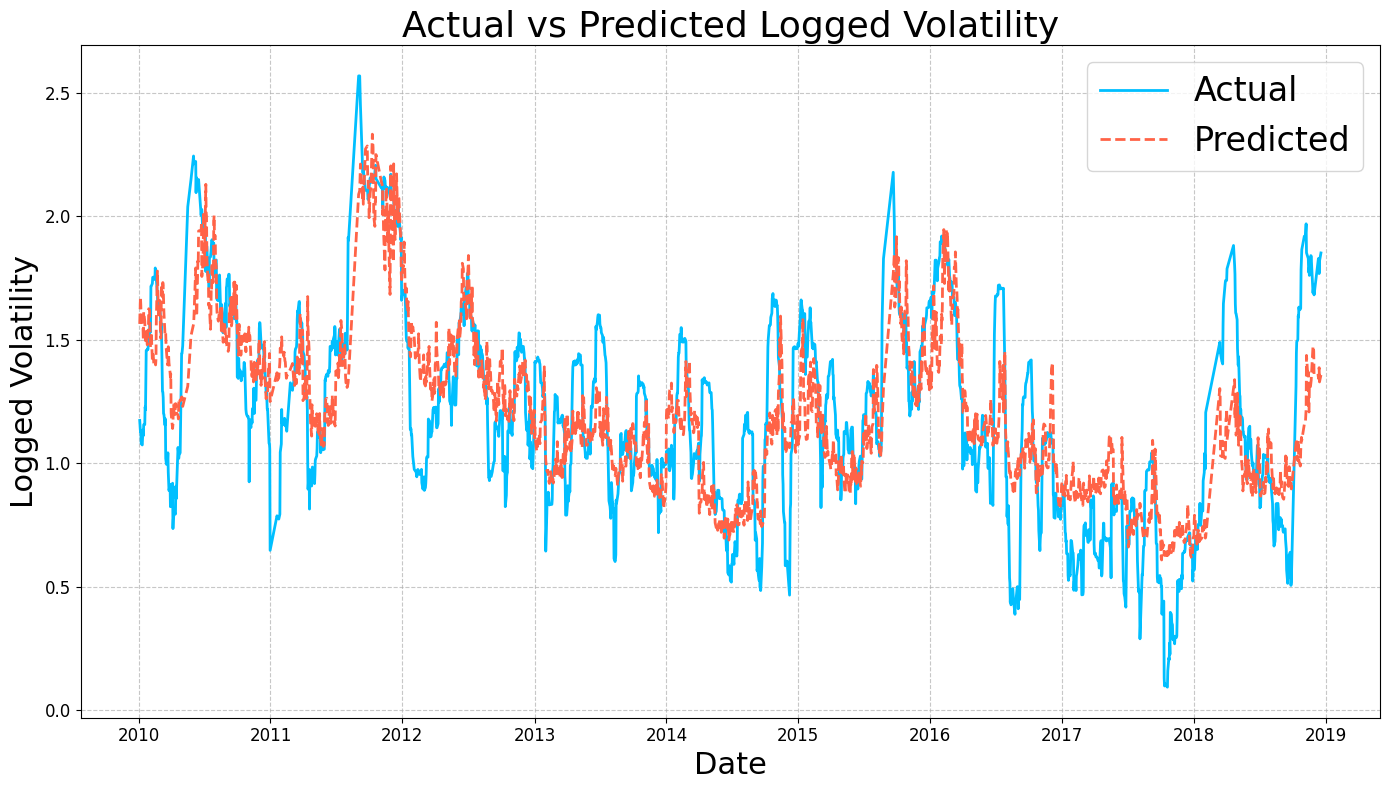

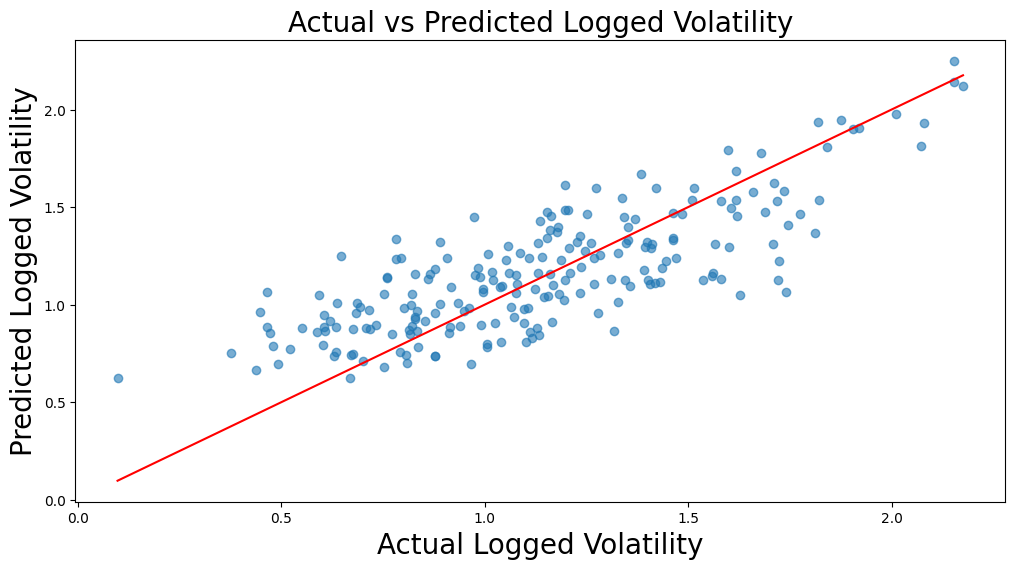

In [73]:
# MAIN PREDICTION

np.random.seed(1007987742)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + Interest_Rates + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Calculate baseline MSE
baseline_pred = np.mean(train_df['Logged_Volatility']) # averaging out all logged volatility as a predictive measure
baseline_mse = mean_squared_error(test_df['Logged_Volatility'], [baseline_pred] * len(test_df)) 
print(f'Baseline MSE: {baseline_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(cleaned_df)
all_true_values = cleaned_df['Logged_Volatility']  # Assuming 'Logged_Volatility' is the target column
all_mse = mean_squared_error(all_true_values, all_predictions)
print(f'Entire Dataset MSE: {all_mse}')

# Line plot of actual vs predicted
plt.figure(figsize=(14, 8))  # Increase figure size for better visibility

# Plotting actual and predicted values
plt.plot(cleaned_df.index, cleaned_df['Logged_Volatility'], label='Actual', color='deepskyblue', linewidth=2)
plt.plot(cleaned_df.index, all_predictions, label='Predicted', color='tomato', linestyle='--', linewidth=2)

# Customizing labels, title, and legend
plt.xlabel('Date', fontsize=22)
plt.ylabel('Logged Volatility', fontsize=22)
plt.title('Actual vs Predicted Logged Volatility', fontsize=26)
plt.legend(fontsize=24)

# Adding grid lines and improving readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize ticks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility', fontsize=20)
plt.ylabel('Predicted Logged Volatility', fontsize=20)
plt.title('Actual vs Predicted Logged Volatility', fontsize=20)
plt.show()

Let's test other models for prediction

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     401.9
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:42:49   Log-Likelihood:                -44.007
No. Observations:                1734   AIC:                             104.0
Df Residuals:                    1726   BIC:                             147.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

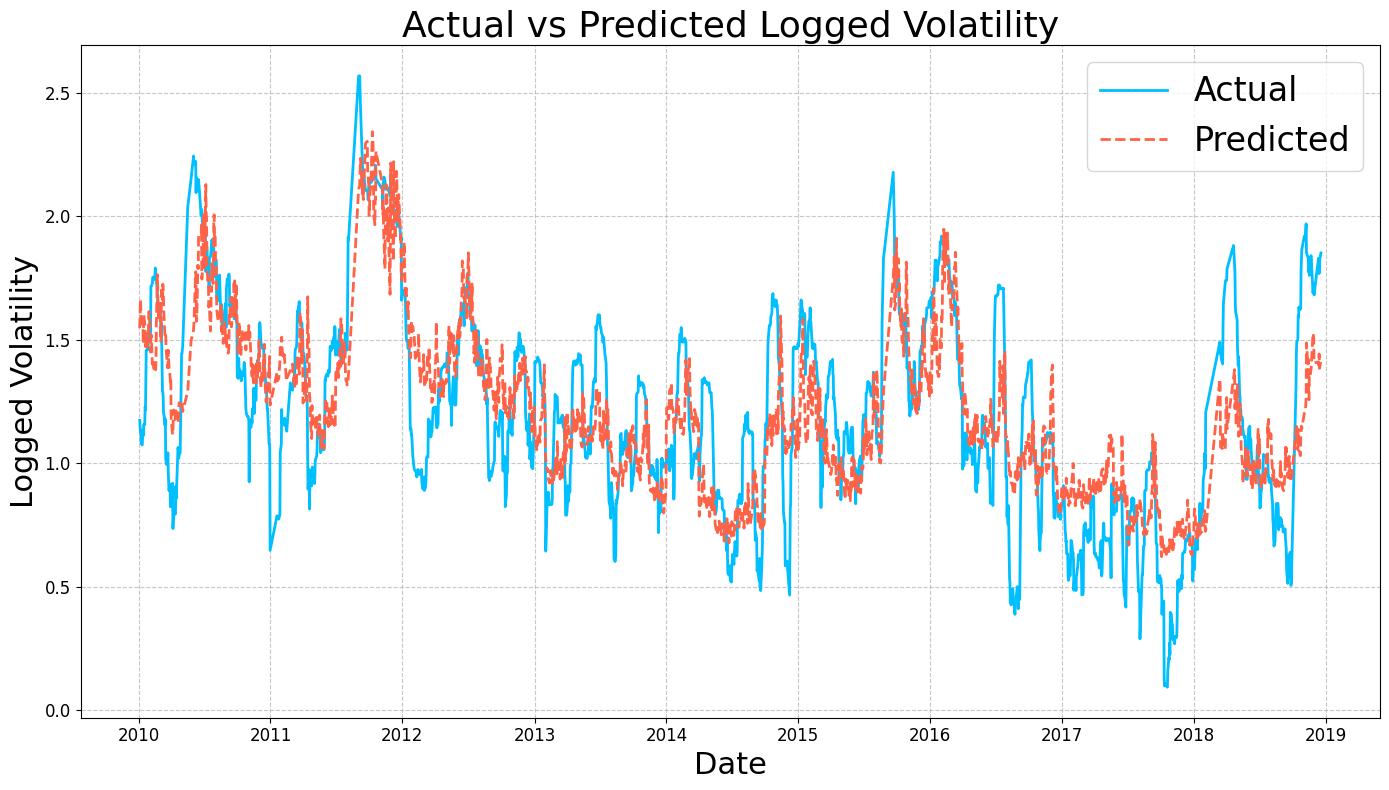

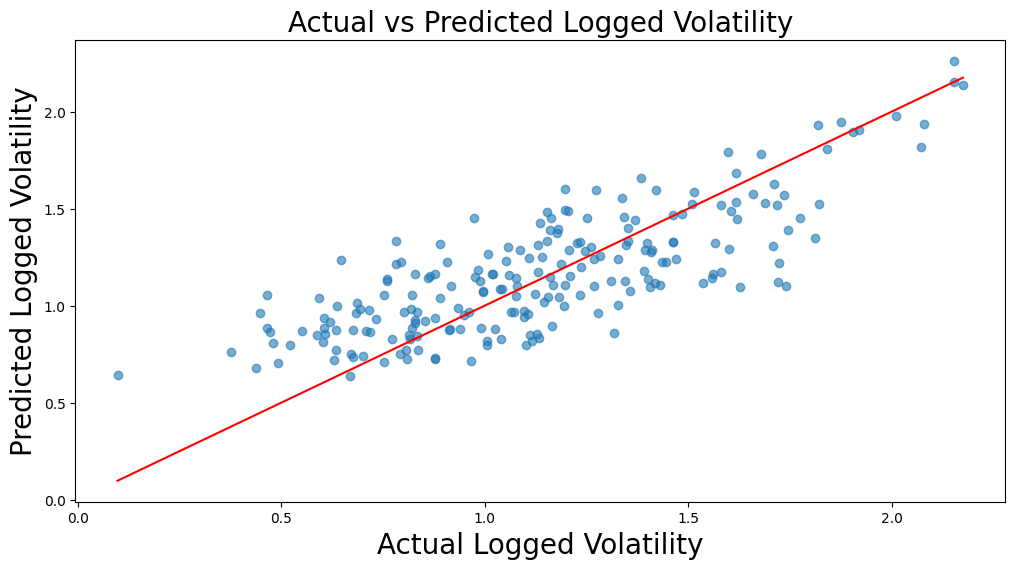

In [75]:
# MAIN PREDICTION

np.random.seed(1007987742)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Calculate baseline MSE
baseline_pred = np.mean(train_df['Logged_Volatility']) # averaging out all logged volatility as a predictive measure
baseline_mse = mean_squared_error(test_df['Logged_Volatility'], [baseline_pred] * len(test_df)) 
print(f'Baseline MSE: {baseline_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(cleaned_df)
all_true_values = cleaned_df['Logged_Volatility']  # Assuming 'Logged_Volatility' is the target column
all_mse = mean_squared_error(all_true_values, all_predictions)
print(f'Entire Dataset MSE: {all_mse}')

# Line plot of actual vs predicted
plt.figure(figsize=(14, 8))  # Increase figure size for better visibility

# Plotting actual and predicted values
plt.plot(cleaned_df.index, cleaned_df['Logged_Volatility'], label='Actual', color='deepskyblue', linewidth=2)
plt.plot(cleaned_df.index, all_predictions, label='Predicted', color='tomato', linestyle='--', linewidth=2)

# Customizing labels, title, and legend
plt.xlabel('Date', fontsize=22)
plt.ylabel('Logged Volatility', fontsize=22)
plt.title('Actual vs Predicted Logged Volatility', fontsize=26)
plt.legend(fontsize=24)

# Adding grid lines and improving readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize ticks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility', fontsize=20)
plt.ylabel('Predicted Logged Volatility', fontsize=20)
plt.title('Actual vs Predicted Logged Volatility', fontsize=20)
plt.show()

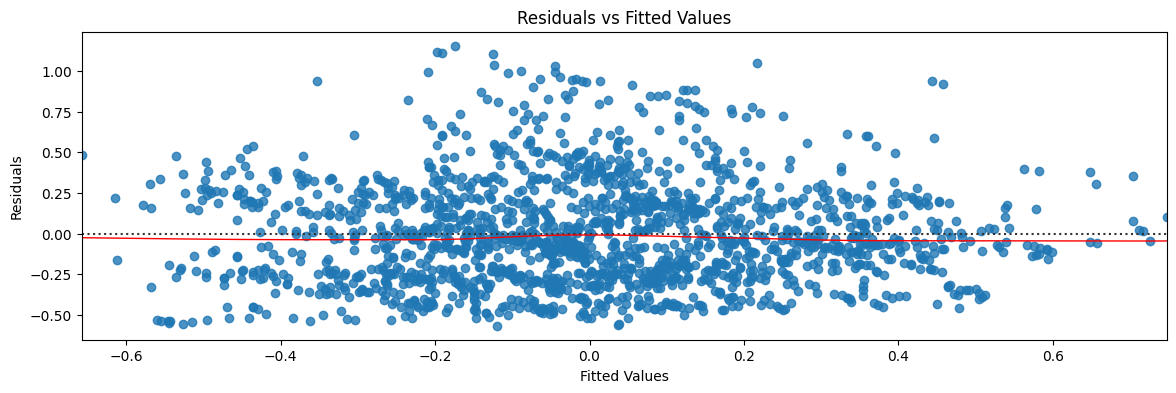

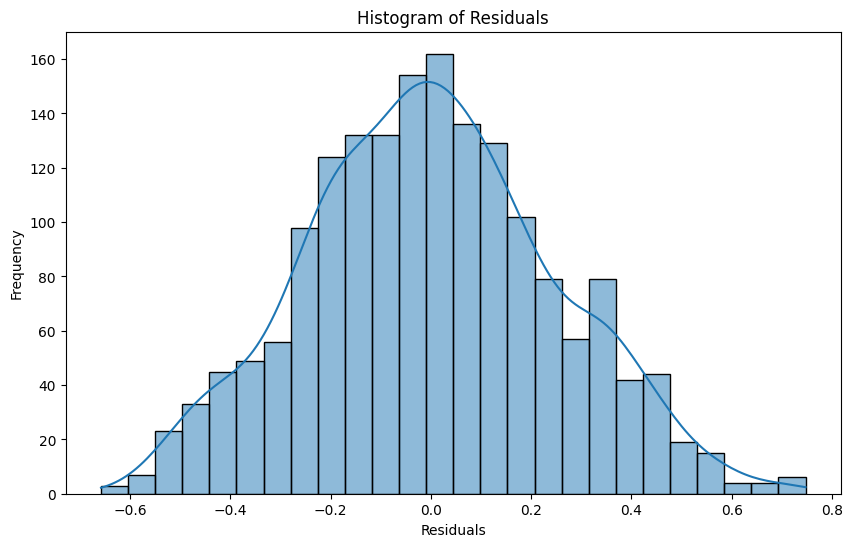

In [77]:
# Extract residuals and fitted values
resids = train_model.resid
fitted_values = train_model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(train_df.index, train_model.resid)

Overfitted model:

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     270.2
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          1.03e-307
Time:                        21:54:49   Log-Likelihood:                -457.62
No. Observations:                1927   AIC:                             933.2
Df Residuals:                    1918   BIC:                             983.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

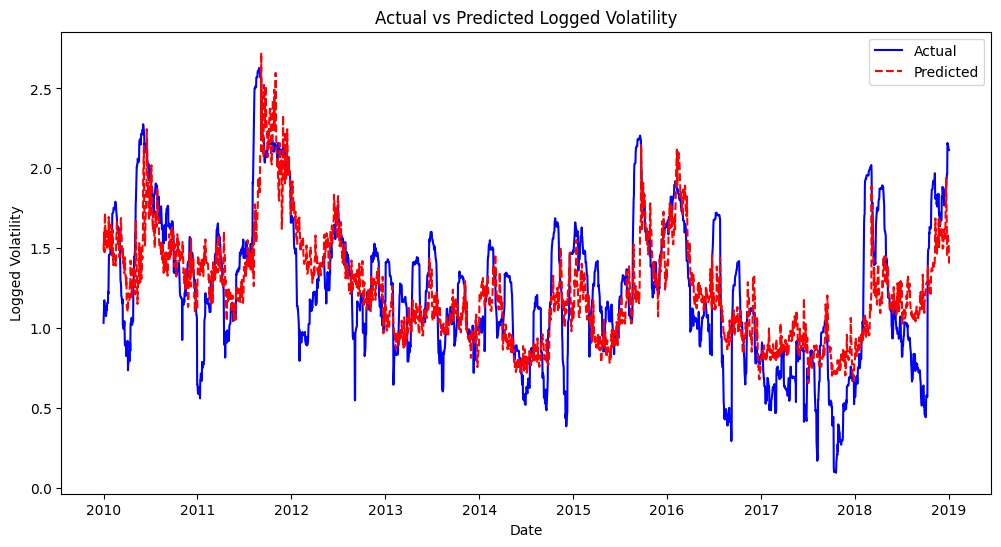

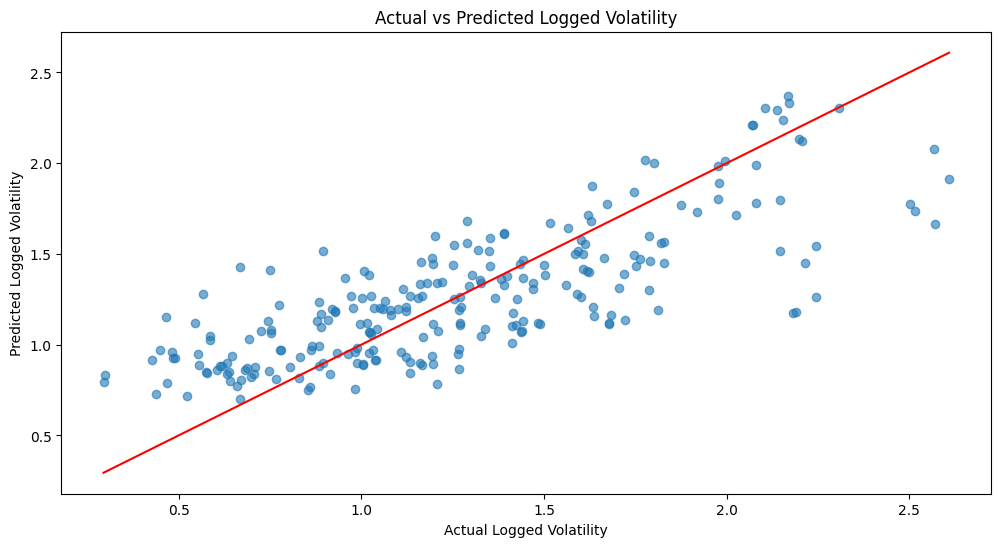

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data
formula = 'Logged_Volatility ~ VIX_Lag_One_Month + Volatility_Lag_One_Month + Volume + GDP_Growth + Unemployment_Rate + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(combined_df)

# Line plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Logged_Volatility'], label='Actual', color='blue')
plt.plot(combined_df.index, all_predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility')
plt.ylabel('Predicted Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.show()

                            OLS Regression Results                            
Dep. Variable:      Logged_Volatility   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1530.
Date:                Mon, 17 Jun 2024   Prob (F-statistic):               0.00
Time:                        00:41:33   Log-Likelihood:                 829.69
No. Observations:                1734   AIC:                            -1643.
Df Residuals:                    1726   BIC:                            -1600.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

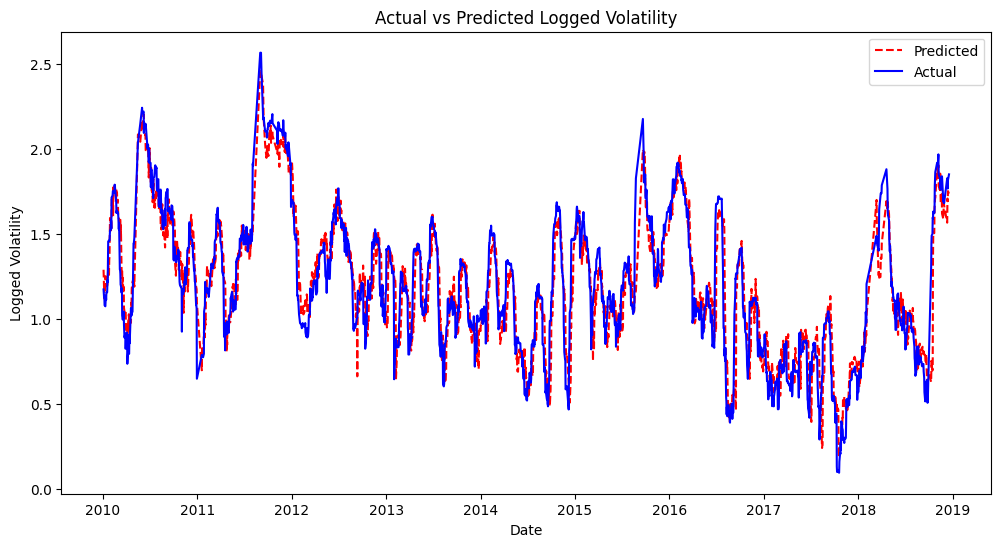

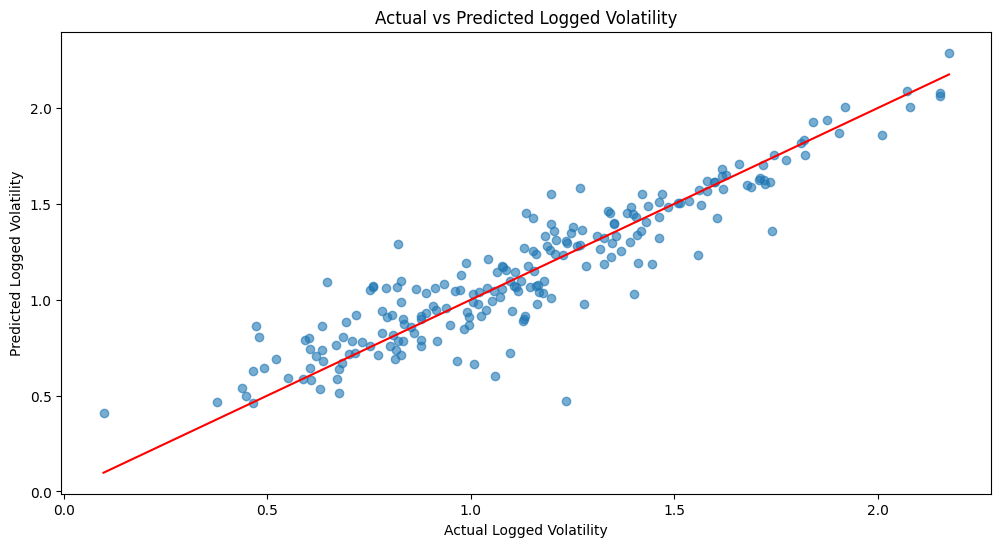

In [72]:
# TEST PREDICTION

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Step 1: Split the data
train_df, temp_df = train_test_split(cleaned_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 2: Fit the model on training data

formula = 'Logged_Volatility ~ VIX_Lag_One_Month + volatility_lag_1week + Volatility_Lag_One_Month + Volume + US_Dollar_Index + Corporate_Bond_Yields + Ten_Year_Treasury_Yield'
train_model = smf.ols(formula=formula, data=train_df).fit()
print(train_model.summary())

# Step 3: Validate the model
val_predictions = train_model.predict(val_df)
val_mse = mean_squared_error(val_df['Logged_Volatility'], val_predictions)
print(f'Validation MSE: {val_mse}')

# Step 4: Test the model
test_predictions = train_model.predict(test_df)
test_mse = mean_squared_error(test_df['Logged_Volatility'], test_predictions)
print(f'Test MSE: {test_mse}')

# Calculate baseline MSE
baseline_pred = np.mean(train_df['Logged_Volatility']) # averaging out all logged volatility as a predictive measure
baseline_mse = mean_squared_error(test_df['Logged_Volatility'], [baseline_pred] * len(test_df)) 
print(f'Baseline MSE: {baseline_mse}')

# Predict on the entire dataset for visualization
all_predictions = train_model.predict(cleaned_df)
all_true_values = cleaned_df['Logged_Volatility']  # Assuming 'Logged_Volatility' is the target column
all_mse = mean_squared_error(all_true_values, all_predictions)
print(f'Entire Dataset MSE: {all_mse}')

# Line plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(cleaned_df.index, all_predictions, label='Predicted', color='red', linestyle='--')
plt.plot(cleaned_df.index, cleaned_df['Logged_Volatility'], label='Actual', color='blue')
plt.xlabel('Date')
plt.ylabel('Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Logged_Volatility'], test_predictions, alpha=0.6)
plt.plot([min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], [min(test_df['Logged_Volatility']), max(test_df['Logged_Volatility'])], color='red')  # Line of perfect prediction
plt.xlabel('Actual Logged Volatility')
plt.ylabel('Predicted Logged Volatility')
plt.title('Actual vs Predicted Logged Volatility')
plt.show()

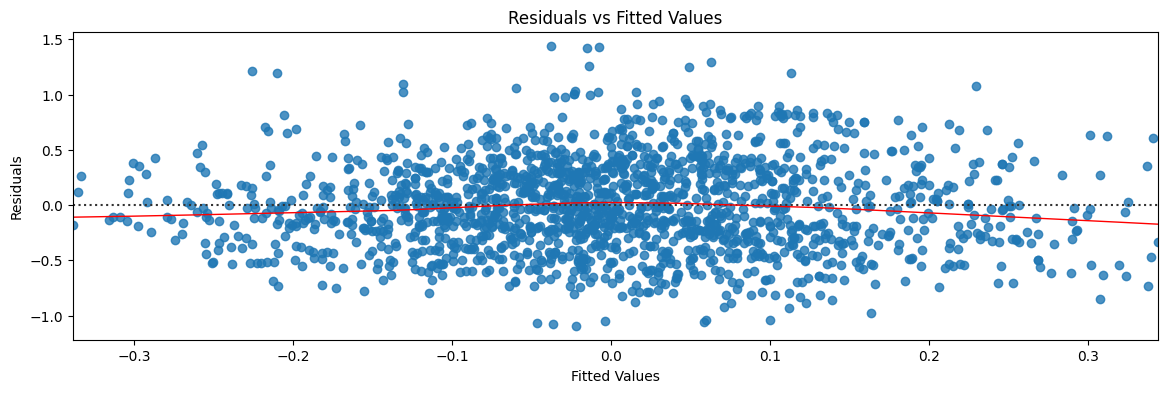

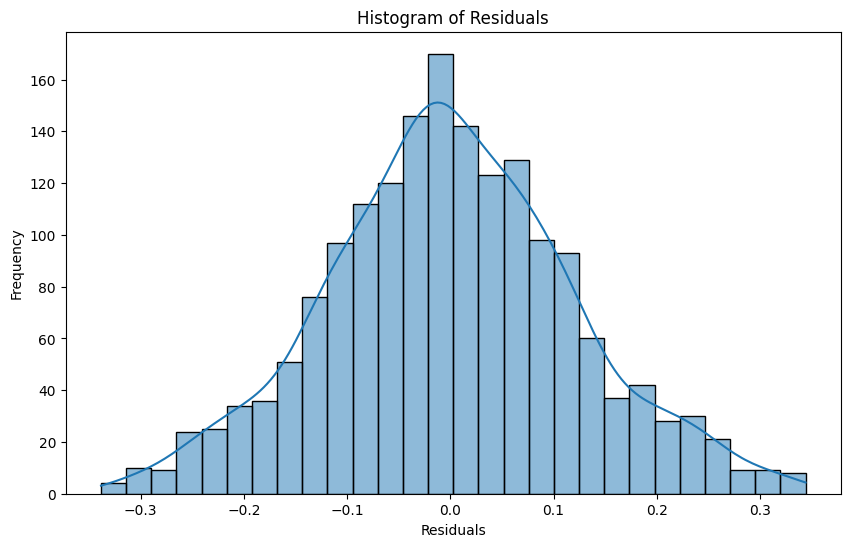

In [ ]:
# Extract residuals and fitted values
resids = train_model.resid
fitted_values = train_model.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(14, 4))
sns.residplot(x=resids, y=fitted_values, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Histogram of residuals to check for normality
plt.figure(figsize=(10, 6))
sns.histplot(resids, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()